In [ ]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
ticker = "hdfcbank.NS"

start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 1, 26)


data = yf.download(ticker, start = start_date , end = end_date , interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# #  for csv file

# data = pd.read_csv('data.csv')


In [ ]:
data.reset_index(inplace=True)

In [ ]:
data = data.dropna()

In [ ]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1005,2024-01-18,1494.000000,1515.000000,1480.050049,1486.150024,1486.150024,80535465
1006,2024-01-19,1505.949951,1510.250000,1468.400024,1470.650024,1470.650024,54800269
1007,2024-01-23,1465.000000,1474.699951,1425.000000,1427.349976,1427.349976,57734701
1008,2024-01-24,1380.250000,1458.449951,1380.250000,1455.900024,1455.900024,43002202
1009,2024-01-25,1452.500000,1457.349976,1419.400024,1434.900024,1434.900024,49470926


In [ ]:
data.rename(columns={'Datetime': 'Date'}, inplace=True)


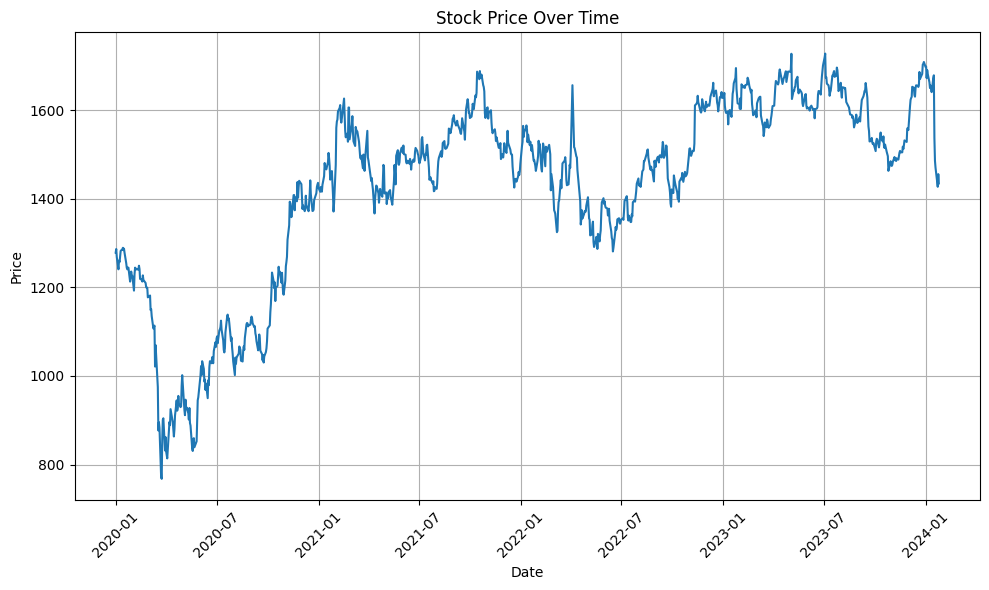

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot( data['Date'] ,  data['Close'],linestyle='-')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

# lstm here

Step: 1, MSE: 0.006407006178051233
Step: 2, MSE: 0.004962071310728788
Step: 3, MSE: 0.0019946377724409103
Step: 4, MSE: 0.003939079586416483
Step: 5, MSE: 0.0022712871432304382
Step: 6, MSE: 0.002697993302717805
Step: 7, MSE: 0.003123800503090024
Step: 8, MSE: 0.0024851190391927958
Step: 9, MSE: 0.00413895957171917
Step: 10, MSE: 0.002930019749328494
Step: 11, MSE: 0.0040179467760026455
Step: 12, MSE: 0.002631044015288353
Step: 13, MSE: 0.0031975824385881424
Step: 14, MSE: 0.0025383986067026854
Best step: 3, Best MSE: 0.0019946377724409103
Best step: 3
Epoch 1/10
26/26 [==============================] - 5s 8ms/step - loss: 0.2321
Epoch 2/10
26/26 [==============================] - 0s 9ms/step - loss: 0.0158
Epoch 3/10
26/26 [==============================] - 0s 9ms/step - loss: 0.0072
Epoch 4/10
26/26 [==============================] - 0s 9ms/step - loss: 0.0041
Epoch 5/10
26/26 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 6/10
26/26 [============================

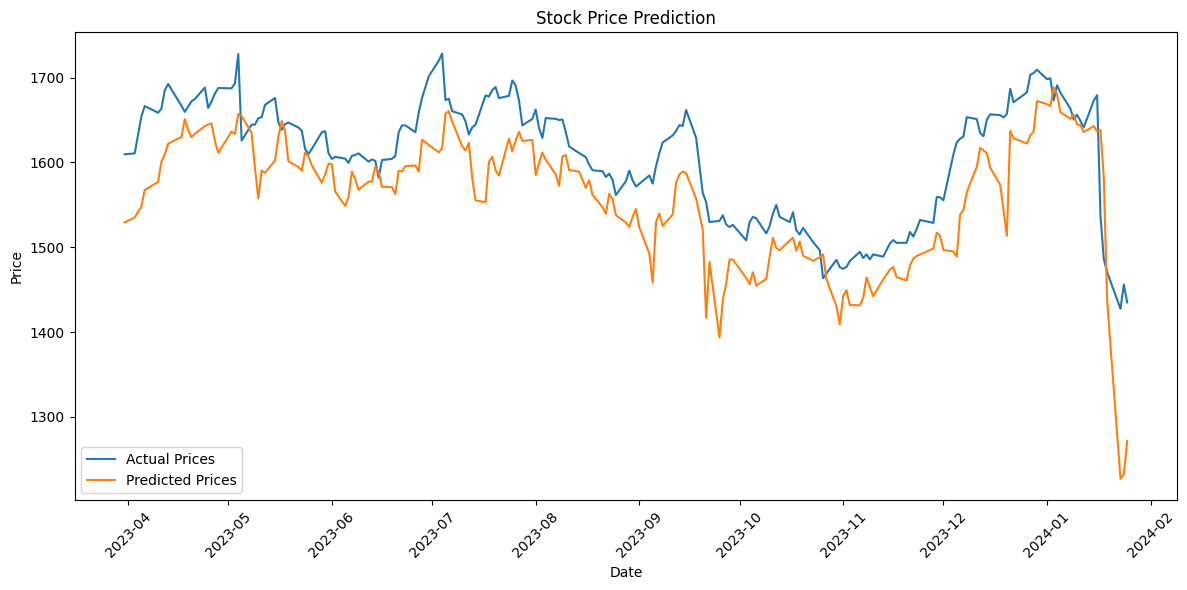

In [ ]:

# Use 'Close' price and 'Volume' for prediction
closing_prices = data['Close'].values.reshape(-1, 1)
volumes = data['Volume'].values.reshape(-1, 1)

# Normalize data using Min-Max scaling
scaler_price = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler_price.fit_transform(closing_prices)

scaler_volume = MinMaxScaler(feature_range=(0, 1))
volumes_scaled = scaler_volume.fit_transform(volumes)

# Concatenate closing prices and volumes
combined_data = np.concatenate((closing_prices_scaled, volumes_scaled), axis=1)

# Prepare data for LSTM
def create_dataset(dataset, time_steps):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), :])
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

# Choose number of time steps for LSTM
def train_model_with_steps(step):
    # Choose number of time steps for LSTM
    time_steps = step

    # Create input sequences and labels
    X, y = create_dataset(combined_data, time_steps)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate model
    mse = model.evaluate(X_test, y_test, verbose=0)
    return mse

# Iterate over different step values and find the best one
best_step = None
best_mse = float('inf')


# ///////////////////////////////////////////////////////////////////////////

for step in range(1, 15):  # Try step values from 1 to 20
    mse = train_model_with_steps(step)
    print(f"Step: {step}, MSE: {mse}")
    if mse < best_mse:
        best_mse = mse
        best_step = step

print(f"Best step: {best_step}, Best MSE: {best_mse}")
best_step = max(best_step,3)
print(f"Best step: {best_step}")

# Train the final model with the best step value
X_final, y_final = create_dataset(combined_data, best_step)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.2, shuffle=False)

final_model = Sequential()
final_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_final.shape[1], X_train_final.shape[2])))
final_model.add(LSTM(units=50, return_sequences=False))
final_model.add(Dense(units=1))
final_model.compile(optimizer='adam', loss='mean_squared_error')
final_model.fit(X_train_final, y_train_final, epochs=10, batch_size=32, verbose=1)


# Make predictions
predicted_prices_scaled = final_model.predict(X_test_final)

# Inverse scaling for predicted prices
predicted_prices = scaler_price.inverse_transform(predicted_prices_scaled)
y_test_real = scaler_price.inverse_transform(y_test_final.reshape(-1, 1))  # Reshape y_test before inverse transformation

# Plot actual and predicted prices with dates
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][-len(y_test_real):], y_test_real, label='Actual Prices')
plt.plot(data['Date'][-len(predicted_prices):], predicted_prices, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
# print(predicted_prices)

In [ ]:
# print(data['Date'][-len(predicted_prices):])

In [ ]:
predicted_prices[-1]

array([1271.6647], dtype=float32)

In [ ]:
import json
from datetime import datetime

# Sample predicted prices and dates
dates = data['Date'][-len(predicted_prices):]

# Convert predicted prices from NumPy array to Python list
predicted_prices_list = predicted_prices.tolist()


# Define the ticker symbol
ticker_symbol = ticker  # Replace this with the actual ticker symbol

# Create a list to store data
data_list = []

# Iterate over the arrays and populate the list
for price, date in zip(predicted_prices_list, dates):
    data_list.append({
        "index": date.strftime('%Y-%m-%d'),
        "close": price[0],
        "ticker": ticker_symbol
    })

# Define the file path
file_path = "predicted_prices.json"

# Save the JSON data to a file
with open(file_path, "w") as json_file:
    json.dump(data_list, json_file, indent=4)

print(f"JSON data saved to {file_path}")


JSON data saved to predicted_prices.json


In [ ]:
#  # Plot candlestick chart
# plt.figure(figsize=(50, 20))

# for i in range(len(data)):
#     if data['Close'][i] > data['Open'][i]:
#         plt.plot([data['Date'][i], data['Date'][i]], [data['Open'][i], data['Close'][i]], color='green', linewidth=2)
#         plt.plot([data['Date'][i], data['Date'][i]], [data['Low'][i], data['High'][i]], color='green', linewidth=1)
#     else:
#         plt.plot([data['Date'][i], data['Date'][i]], [data['Open'][i], data['Close'][i]], color='red', linewidth=2)
#         plt.plot([data['Date'][i], data['Date'][i]], [data['Low'][i], data['High'][i]], color='red', linewidth=1)

# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Candlestick Chart')
# plt.grid(True)
# plt.show()


In [ ]:
# !pip install pymongo

# import pymongo

# # MongoDB connection parameters
# mongodb_url = "mongodb://localhost:27017/"
# database_name = "stocks"
# collection_name = "RELIANCE.NS_predicted"

# # Connect to MongoDB server
# client = pymongo.MongoClient(mongodb_url)

# # Access or create the database
# database = client[database_name]

# # Access or create the collection
# collection = database[collection_name]

# # Insert the data into the collection
# collection.insert_one(data_dict)

# print("Data inserted into MongoDB collection.")


In [ ]:
# Choose the number of time steps for prediction
time_steps = best_step
# time_steps = 3

# Prepare the most recent data for prediction
recent_data = combined_data[-time_steps:].reshape(1, time_steps, combined_data.shape[1])

# Predict the closing price for the next day
predicted_price_scaled = final_model.predict(recent_data)

# Inverse scaling to get the actual predicted price
predicted_price = scaler_price.inverse_transform(predicted_price_scaled)

print(f"Predicted closing price for the next day: {predicted_price[0][0]}")


1/1 [==============================] - 0s 27ms/step
Predicted closing price for the next day: 1266.9375


# write the model here

In [ ]:
# class StockEnvironment:
#     def __init__(self, data, initial_cash=10000, max_steps=100):
#         self.data = data  # Stock price data (e.g., closing prices)
#         self.initial_cash = initial_cash
#         self.max_steps = max_steps
#         self.reset()

#         # Define observation space and action space
#         self.state_size = len(data)  # Length of historical data sequence
#         self.action_size = 3  # Buy, Sell, Hold

#     def reset(self):
#         self.current_step = 0
#         self.cash = self.initial_cash
#         self.shares_owned = 0
#         self.portfolio_value = self.cash
#         self.prev_portfolio_value = self.portfolio_value
#         self.state = self._next_observation()
#         return self.state

#     def _next_observation(self):
#         end = self.current_step + 10
#         obs = self.data[self.current_step:end]
#         self.current_step += 1
#         return obs

#     def _take_action(self, action):
#         current_price = self.data[self.current_step - 1]
#         if action == 0:  # Buy
#             if self.cash >= current_price:
#                 self.shares_owned += 1
#                 self.cash -= current_price
#         elif action == 1:  # Sell
#             if self.shares_owned > 0:
#                 self.shares_owned -= 1
#                 self.cash += current_price

#     def step(self, action):
#         self._take_action(action)
#         self.prev_portfolio_value = self.portfolio_value
#         self.portfolio_value = self.cash + (self.shares_owned * self.data[self.current_step - 1])
#         reward = self.portfolio_value - self.prev_portfolio_value
#         self.state = self._next_observation()
#         done = self.current_step >= len(self.data) - 1 or self.current_step >= self.max_steps
#         return self.state, reward, done, {}

# # Example usage:
# # Assuming `stock_data` is an array containing historical stock prices
# # Initialize environment
# env = StockEnvironment(train_data)

# # Define state size and action size
# state_size = env.state_size
# action_size = env.action_size

# # Training loop remains the same
# # Initialize DQN agent
# agent = DQNAgent(state_size, action_size)

# # Training loop
# batch_size = 32
# num_episodes = 1000
# for e in range(num_episodes):
#     state = env.reset()
#     state = np.reshape(state, [1, state_size])
#     for time in range(500):
#         action = agent.act(state)
#         next_state, reward, done, _ = env.step(action)
#         next_state = np.reshape(next_state, [1, state_size])
#         agent.remember(state, action, reward, next_state, done)
#         state = next_state
#         if done:
#             print("episode: {}/{}, score: {}, e: {:.2}".format(e, num_episodes, time, agent.epsilon))
#             break
#         if len(agent.memory) > batch_size:
#             agent.replay(batch_size)


In [ ]:
# import numpy as np
# import random
# import tensorflow as tf
# from collections import deque

# class DQNAgent:
#     def __init__(self, state_size, action_size):
#         self.state_size = state_size
#         self.action_size = action_size
#         self.memory = deque(maxlen=2000)
#         self.gamma = 0.95  # Discount rate
#         self.epsilon = 1.0  # Exploration rate
#         self.epsilon_min = 0.01
#         self.epsilon_decay = 0.995
#         self.learning_rate = 0.001
#         self.model = self._build_model()

#     def _build_model(self):
#         model = tf.keras.models.Sequential([
#             tf.keras.layers.Dense(24, input_dim=self.state_size, activation='relu'),
#             tf.keras.layers.Dense(24, activation='relu'),
#             tf.keras.layers.Dense(self.action_size, activation='linear')
#         ])
#         model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
#         return model

#     def remember(self, state, action, reward, next_state, done):
#         self.memory.append((state, action, reward, next_state, done))

#     def act(self, state):
#         if np.random.rand() <= self.epsilon:
#             return random.randrange(self.action_size)
#         else:
#             return np.argmax(self.model.predict(state)[0])

#     def replay(self, batch_size):
#         minibatch = random.sample(self.memory, batch_size)
#         for state, action, reward, next_state, done in minibatch:
#             target = reward
#             if not done:
#                 target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
#             target_f = self.model.predict(state)
#             target_f[0][action] = target
#             self.model.fit(state, target_f, epochs=1, verbose=0)
#         if self.epsilon > self.epsilon_min:
#             self.epsilon *= self.epsilon_decay

# # Define your environment, state, action, and reward functions
# # Implement functions for data preprocessing, state representation, and reward calculation

# # Initialize DQN agent
# state_size = 10  # Example: size of feature vector representing state
# action_size = 3  # Example: buy, sell, hold
# agent = DQNAgent(state_size, action_size)

# # # Training loop
# # batch_size = 32
# # num_episodes = 1000
# # for e in range(num_episodes):
# #     # Reset environment, initialize state
# #     state = env.reset()
# #     state = np.reshape(state, [1, state_size])
# #     for time in range(500):  # Example: maximum number of time steps per episode
# #         # Agent takes action based on current state
# #         action = agent.act(state)
# #         next_state, reward, done, _ = env.step(action)
# #         next_state = np.reshape(next_state, [1, state_size])
# #         # Store experience in replay memory
# #         agent.remember(state, action, reward, next_state, done)
# #         state = next_state
# #         if done:
# #             print("episode: {}/{}, score: {}, e: {:.2}".format(e, num_episodes, time, agent.epsilon))
# #             break
# #         # Train agent by replaying experiences from memory
# #         if len(agent.memory) > batch_size:
# #             agent.replay(batch_size)


# gcn


In [ ]:
ticker = "hdfcbank.NS"

start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 4, 16)


data = yf.download(ticker, start = start_date , end = end_date , interval = "1d")

data.reset_index(inplace=True)
data = data.dropna()
print(data.tail())

[*********************100%%**********************]  1 of 1 completed

           Date         Open         High          Low        Close  \
1057 2024-04-08  1554.949951  1557.250000  1541.550049  1546.599976   
1058 2024-04-09  1554.849976  1554.849976  1540.300049  1548.550049   
1059 2024-04-10  1549.900024  1549.900024  1532.949951  1536.349976   
1060 2024-04-12  1521.000000  1529.849976  1513.449951  1518.949951   
1061 2024-04-15  1497.550049  1510.000000  1492.050049  1494.699951   

        Adj Close    Volume  
1057  1546.599976  10241470  
1058  1548.550049  10942247  
1059  1536.349976  13903700  
1060  1518.949951  20542104  
1061  1494.699951  11707624  


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch.nn.functional as F


# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, adj):
        x = F.relu(self.fc1(x))
        x = torch.mm(adj, x)
        x = self.fc2(x)
        return x

# Function to train the model
def train_model(model, adj, features, labels, epochs=100, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(features, adj)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

# Function to make predictions
def predict(model, adj, features):
    model.eval()
    with torch.no_grad():
        output = model(features, adj)
    return output

# Example usage
# Assuming you have data in the form of numpy arrays: features, labels, adjacency_matrix
import numpy as np

# Assuming 'closing_prices' is a numpy array containing the closing prices of the stock
closing_prices = data['Close'].values  # Replace [...] with your actual closing prices

# Features: Use the closing prices as features
features = closing_prices[:-1]  # Exclude the last day's closing price
features = features.reshape(-1, 1)  # Reshape to a column vector
dates = data['Date']


# Labels: Shift the closing prices by one day to get the next day's closing prices
labels = closing_prices[1:]  # Exclude the first day's closing price
labels = labels.reshape(-1, 1)  # Reshape to a column vector



# Number of stocks (equal to the number of rows or columns in the features matrix)
num_stocks = features.shape[0]

# Construct adjacency matrix
adjacency_matrix = np.eye(num_stocks)  # Identity matrix with diagonal elements as 1

# Normalize features and labels
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)
labels_normalized = scaler.fit_transform(labels.reshape(-1, 1))

# Convert numpy arrays to PyTorch tensors
features_tensor = torch.FloatTensor(features_normalized)
labels_tensor = torch.FloatTensor(labels_normalized)
adj_tensor = torch.FloatTensor(adjacency_matrix)

# Define model parameters
input_dim = features_tensor.shape[1]
hidden_dim = 64
output_dim = 1

# Initialize model
model = GCN(input_dim, hidden_dim, output_dim)

# Train the model
train_model(model, adj_tensor, features_tensor, labels_tensor)

# Make predictions
predicted_normalized = predict(model, adj_tensor, features_tensor)
predicted = scaler.inverse_transform(predicted_normalized.numpy())

# Print predicted values
print("Predicted values:")
print(predicted)


Epoch [10/100], Loss: 0.008185027167201042
Epoch [20/100], Loss: 0.003994595725089312
Epoch [30/100], Loss: 0.0014003533869981766
Epoch [40/100], Loss: 0.0008038409287109971
Epoch [50/100], Loss: 0.0006420657155103981
Epoch [60/100], Loss: 0.0006025954498909414
Epoch [70/100], Loss: 0.0005802856758236885
Epoch [80/100], Loss: 0.0005633902037516236
Epoch [90/100], Loss: 0.0005567604093812406
Epoch [100/100], Loss: 0.0005562151782214642
Predicted values:
[[1283.2739]
 [1291.5027]
 [1272.9752]
 ...
 [1551.5846]
 [1538.6259]
 [1520.1438]]


In [ ]:
print(labels.reshape(1,-1).shape)
print(predicted.reshape(1,-1).shape)
print(labels.reshape(1,-1))
print(predicted.reshape(1,-1))

(1, 1009)
(1, 1009)
[[1286.75       1268.40002441 1240.94995117 ... 1427.34997559
  1455.90002441 1434.90002441]]
[[1273.5554 1282.0597 1263.29   ... 1473.9486 1428.7676 1458.5579]]


In [ ]:
print(labels.reshape(1,-1)[0][-1])
print(predicted.reshape(1,-1)[0][-1])

1494.699951171875
1520.1438


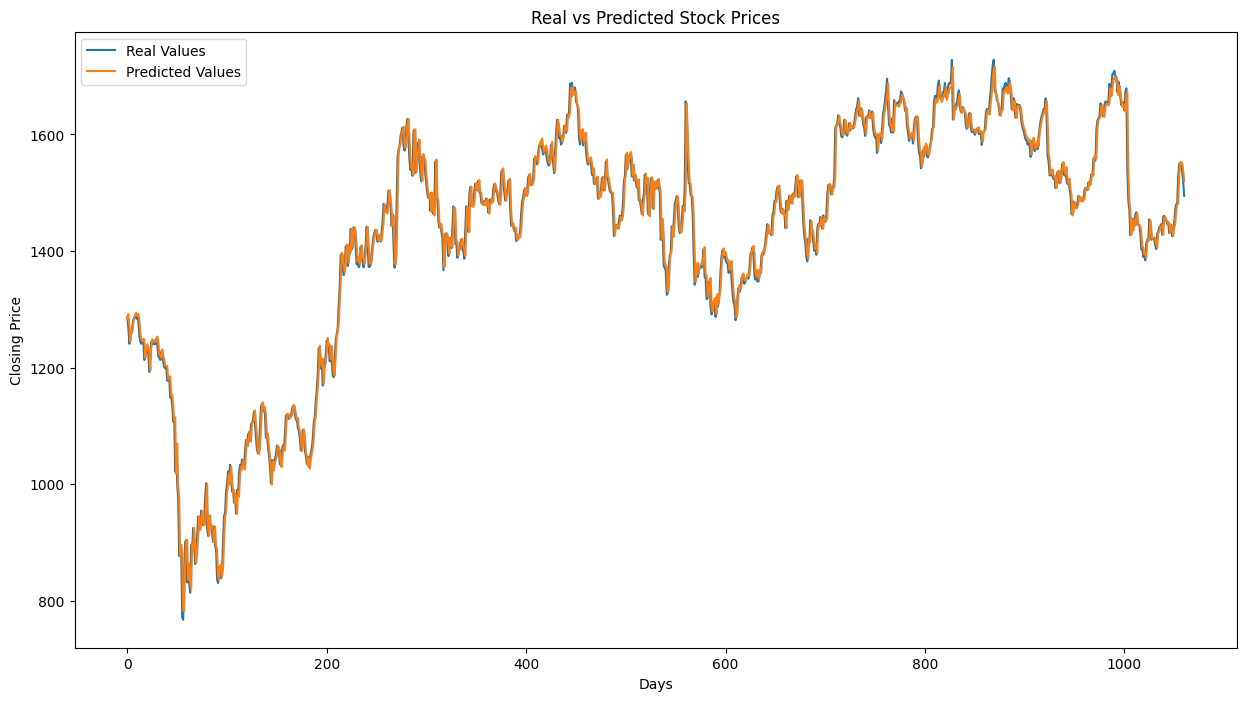

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(labels, label='Real Values')
plt.plot(predicted, label='Predicted Values')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Real vs Predicted Stock Prices')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

# Convert the predicted values to numpy array
predicted_array = predicted.flatten()

# Convert the real values to numpy array
real_array = labels.flatten()

# Calculate the Mean Squared Error
mse = mean_squared_error(real_array, predicted_array)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 512.8414868322657


In [ ]:
# Get the features (closing prices) for the last day in your dataset
last_day_features = features_normalized[-1]  # Assuming features_normalized is your normalized features array

# Convert the last day's features to a PyTorch tensor
last_day_features_tensor = torch.FloatTensor(last_day_features)

# Predict the next day's value
next_day_prediction_normalized = predict(model, adj_tensor, last_day_features_tensor.unsqueeze(0))
next_day_prediction = scaler.inverse_transform(next_day_prediction_normalized.numpy())

print("Predicted closing price for the next day:", next_day_prediction[0][0])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1061x1061 and 1x64)